In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import entropy
from uuid import uuid4 # to give each leaf a distinct name
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [2]:
# Quiz Data

x1s = [2,2,2,2,1,1,1,1,1,1,2,2,1,1,2,2,1,1,1,1]
x2s = [1,2,2,1,1,2,2,1,2,2,2,2,2,2,1,1,1,1,1,2]
x3s = [1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2]
x4s = [1,1,1,3,3,2,2,1,1,1,3,3,2,3,3,3,2,2,1,1]
x5s = [2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1]
ys  = [1,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,1,1,1,0]

data = [x1s, x2s, x3s, x4s, x5s, ys]

examples = []
for i in range(len(x1s)):
    example = []
    for j in range(6):
        example.append(data[j][i])
    examples.append(example)
    
attributes = list(range(5))

**Pseudocode (from AIMA)**
<img src="./dt_algo.png" width=500/>

In [3]:
def dtl(examples, attributes, parent_examples, G):
    if not examples: # leaf node
        val = str(plurality_value(parent_examples)) + "_" + str(uuid4())[:2]
        G.add_node(val, label=str(val).split("_")[0])
        print(f"Adding node {val}")
        return val
    elif len(set(map(classify, examples))) == 1: # leaf node
        val = str(classify(examples[0])) + "_" + str(uuid4())[:2]
        G.add_node(val, label=str(val).split("_")[0])
        print(f"Adding node {val}")
        return val
    elif not attributes: # leaf node
        val = str(plurality_value(examples)) + "_" + str(uuid4())[:2]
        G.add_node(val, label=str(val).split("_")[0])
        print(f"Adding node {val}")
        return val
    
    else:
        # choose next important attribute
        cur_attribute = next_attribte(attributes, examples)
        G.add_node(cur_attribute, label=f"F{cur_attribute+1}")
        print(f"Adding node {cur_attribute}")
        
        for v in value_for_attribute(cur_attribute):
            child_examples = []
            for e in examples:
                if e[cur_attribute] == v:
                    child_examples.append(e)
                    
            child_attributes = attributes.copy()
            child_attributes.remove(cur_attribute)
            ret = dtl(child_examples, child_attributes, examples, G)
            
            print(f"Adding edge ({cur_attribute}, {ret}, value={v})")
            G.add_edge(cur_attribute, ret, decision=v)
    
    return cur_attribute

def plurality_value(examples):
    number_of_ones = 0
    number_of_zeros = 0
    
    for e in examples:
        if e[5] == 0:
            number_of_zeros += 1
        else:
            number_of_ones += 1
    
    if number_of_ones > number_of_zeros:
        return True
    else:
        return False
    
def classify(example):
    y = example[5]
    if y:
        return True
    else:
        return False

def next_attribte(attributes, examples):
    current_entropy = cur_entropy(examples)
    
    d = dict()
    dg = dict()
    for a in attributes:
        d[a] = round(expected_entropy(a, examples),2)
        dg[a] = round(current_entropy - d[a],2)
    
    print(f"Entropies: {d}")
    print(f"Entropy Gains: {dg}")
    return list(dict(sorted(d.items(), key=lambda item: item[1])).keys())[0]

def cur_entropy(examples):
    number_of_zero = 0
    number_of_one = 0
    
    for e in examples:
        if e[5] == 0:
            number_of_zero += 1
        else:
            number_of_one += 1
        
    return entropy([number_of_one, number_of_zero], base=2)

def expected_entropy(attribute, examples):
    all_values = value_for_attribute(attribute)
    
    buckets = dict()
    for v in all_values:
        buckets[v] = [0, 0]
    
    for v in all_values:
        for e in examples:
            if e[attribute] == v:
                if e[5] == 0:
                    buckets[v][0] += 1
                else:
                    buckets[v][1] += 1
    
    
    ret = 0
    for b in buckets.items():
        ret += entropy(b[1], base=2) * sum(b[1]) / len(examples)
        
    return ret

def value_for_attribute(a):
    return set(data[a])

In [4]:
G = nx.DiGraph()
first_attribute = dtl(examples, attributes, list(), G)

Entropies: {0: 0.7, 1: 0.93, 2: 1.0, 3: 0.68, 4: 1.0}
Entropy Gains: {0: 0.3, 1: 0.07, 2: 0.0, 3: 0.32, 4: 0.0}
Adding node 3
Entropies: {0: 0.95, 1: 0.0, 2: 0.94, 4: 0.94}
Entropy Gains: {0: 0.0, 1: 0.95, 2: 0.01, 4: 0.01}
Adding node 1
Adding node True_7c
Adding edge (1, True_7c, value=1)
Adding node False_e0
Adding edge (1, False_e0, value=2)
Adding edge (3, 1, value=1)
Adding node True_ee
Adding edge (3, True_ee, value=2)
Entropies: {0: 0.0, 1: 0.86, 2: 0.8, 4: 0.8}
Entropy Gains: {0: 0.86, 1: 0.0, 2: 0.06, 4: 0.06}
Adding node 0
Adding node True_97
Adding edge (0, True_97, value=1)
Adding node False_f7
Adding edge (0, False_f7, value=2)
Adding edge (3, 0, value=3)


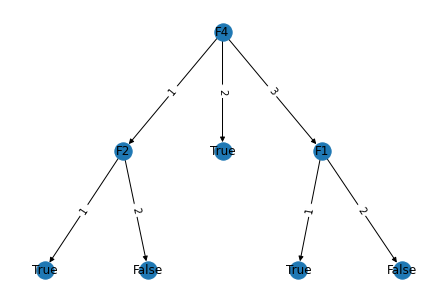

In [5]:
pos = graphviz_layout(G, prog="dot")
nx.draw(G, pos)

node_labels = nx.get_node_attributes(G, "label") # node labels
edge_labels = nx.get_edge_attributes(G, "decision") # edge label
nx.draw_networkx_labels(G, pos, labels=node_labels) # draw nodes
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels) # draw edges
plt.show()